In [14]:
import math

from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

In [3]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [4]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

In [5]:
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [7]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2651.9,541.2,1434.9,502.9,3.9,2.0
std,2.1,2.0,12.6,2208.7,425.5,1175.6,389.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1462.0,297.0,791.0,281.8,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,433.0,1167.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.2,652.0,1723.0,607.0,4.8,2.3
max,42.0,-114.5,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2623.9,535.2,1416.7,497.3,3.9,2.0
std,2.1,2.0,12.5,2109.3,411.8,1078.3,373.5,1.9,1.2
min,32.6,-124.3,2.0,12.0,3.0,14.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1462.8,296.0,786.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2124.0,435.0,1165.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3109.2,639.2,1715.0,598.2,4.8,2.3
max,42.0,-114.3,52.0,21533.0,4492.0,12427.0,4372.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.3
std,116.3
min,15.0
25%,119.8
50%,179.6
75%,264.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.4
std,115.2
min,15.0
25%,118.8
50%,181.3
75%,265.5
max,500.0


In [8]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

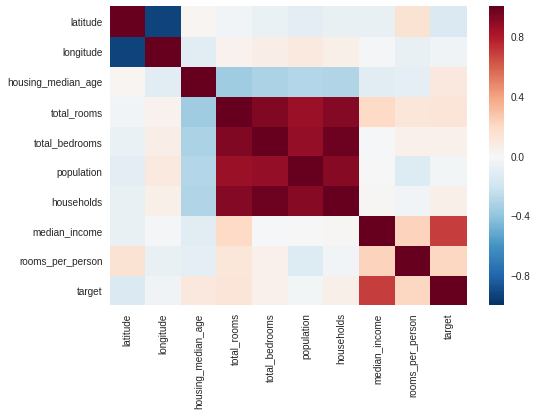

In [15]:
sns.heatmap(correlation_dataframe.corr());

In [16]:
def construct_feature_columns(input_features):
    """
    Creates list of tf feature columns
    Args:
    Returns:
    """
    return set([tf.feature_column.numeric_column(feature) for feature in input_features])

In [17]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Creates batches
    Args:
    Returns:
        tf.Dataset
    """
    features = {key: np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, targets = ds.make_one_shot_iterator().get_next()
    return features, targets

In [20]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    """
    Trains a lin reg model
    Args:
    Returns:
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    my_opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        optimizer=my_opt, 
        feature_columns=construct_feature_columns(training_examples)
    )
    
    
      # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    
     # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        _ = linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period
        )
        
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    # Train the model, starting from the prior state.
      # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 211.00
  period 01 : 185.76
  period 02 : 162.60
  period 03 : 142.55
  period 04 : 129.72
  period 05 : 121.47
  period 06 : 118.20
  period 07 : 117.57
  period 08 : 117.34
  period 09 : 116.37
Model training finished.


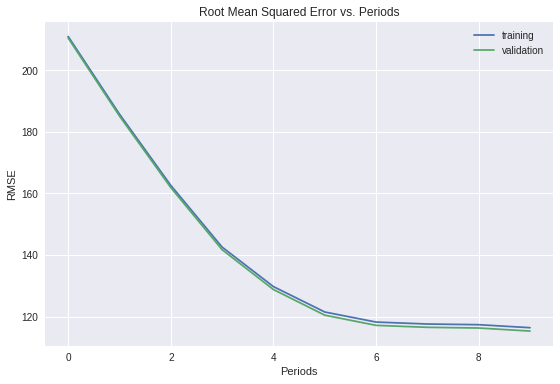

In [21]:
minimal_features = [
    'latitude',
    'longitude',
    'rooms_per_person',
    'median_income'
]


minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

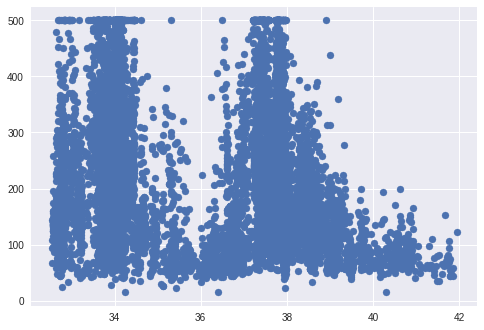

In [22]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

In [24]:
california_housing_dataframe['latitude'].describe()

count   17000.0
mean       35.6
std         2.1
min        32.5
25%        33.9
50%        34.2
75%        37.7
max        42.0
Name: latitude, dtype: float64

In [43]:
def select_and_transform_features(source_df):
    LAT_RANGES = zip(range(32,44), range(33,45))
    selected_examples = pd.DataFrame()
    selected_examples["median_income"] = source_df["median_income"]
    for r in LAT_RANGES:
        selected_examples['latitute_%d_to_%d' % r] = source_df['latitude'].apply(lambda l: 1.0 if l>=r[0] and l<r[1] else .0)
    
    return selected_examples


In [44]:
selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 207.16
  period 01 : 177.53
  period 02 : 149.32
  period 03 : 123.53
  period 04 : 104.49
  period 05 : 91.20
  period 06 : 86.15
  period 07 : 84.05
  period 08 : 83.98
  period 09 : 83.91
Model training finished.


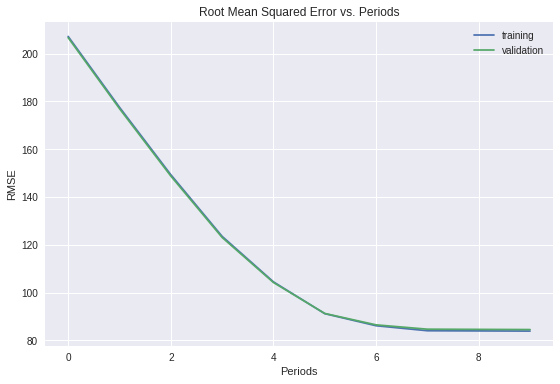

In [46]:
_ = train_model(
    learning_rate=0.03,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

In [48]:
california_housing_dataframe['rooms_per_person'] = california_housing_dataframe['total_rooms'] / california_housing_dataframe['population']

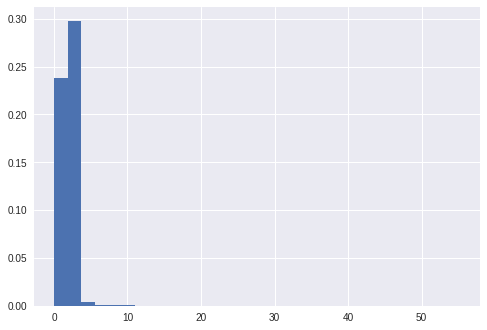

In [63]:
plt.hist(california_housing_dataframe['rooms_per_person'], normed=True, bins=30);

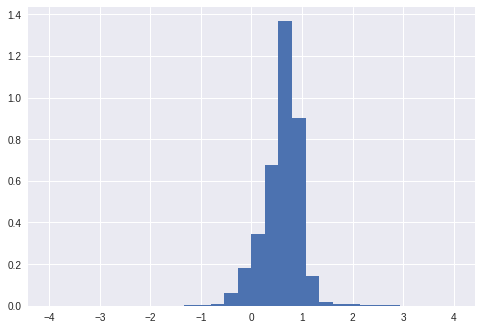

In [64]:
plt.hist(np.log(california_housing_dataframe['rooms_per_person']), normed=True, bins=30);

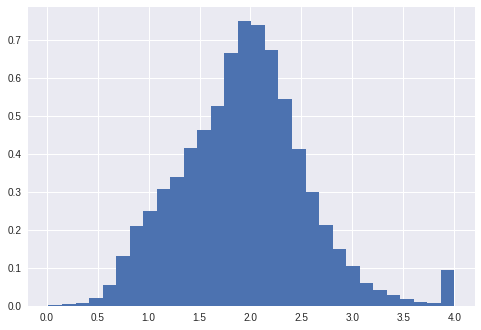

In [65]:
plt.hist(np.where(california_housing_dataframe['rooms_per_person']<4, california_housing_dataframe['rooms_per_person'], 4), normed=True, bins=30);